![dsl logo](https://github.com/BrockDSL/ARCH_Data_Explore/blob/main/dsl_logo.png?raw=true)

# This notebook examines the number of crawls the keywords 'vaccine' 'vaccinated' and vaccination' appear in. It does *not* show how many times these keywords were used in a given period, but rather *in how many crawls* these keywords were found in. 

In [ ]:
import pandas as pd
import requests
import pprint
import re
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 400)

In [ ]:
def download_file(url, filename=None, loud=True):
  
  if not filename:
    filename = url.split('/')[-1]
  
  r = requests.get(url, stream=True)
  if loud:
    total_bytes_dl = 0
    content_len = int(r.headers['Content-Length'])

  with open(filename, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=4096):
          fd.write(chunk)
          if loud:
            total_bytes_dl += 4096
            percent = int((total_bytes_dl / content_len) * 100.0)
            print(f'\rDownload progress of {filename} {total_bytes_dl}/{content_len}: {percent}%',end='')
  r.close()

def get_muni_data():
  download_file("https://brockau.s3.us-east-2.amazonaws.com/url_cv19.csv.gz")
  !gunzip -f url_cv19.csv.gz
  archive_data = pd.read_csv("url_cv19.csv")
  archive_data.drop(columns=['Unnamed: 0', 'index', 'v_comp','v_pos','v_neg','v_neu', 'mime_type_web_server', 'mime_type_tika', 'language'], inplace=True)
  archive_data.crawl_date = pd.to_datetime(archive_data.crawl_date)
  archive_data.content = archive_data.content.astype("string")
  return archive_data

In [ ]:
r = requests.get('https://raw.githubusercontent.com/BrockDSL/ARCH_Data_Explore/main/urls_of_interest.txt')
urls_of_interest = r.text.split()

domains = [
"westlincoln.ca",
"thorold.ca",
"forterie.ca",
"welland.ca",
"niagararegion.ca",
"notl.com",
"wainfleet.ca",
"portcolborne.ca",
"grimsby.ca",
"lincoln.ca",
"pelham.ca",
"niagarafalls.ca",
"stcatharines.ca"]

#Retrieve data 
data = get_muni_data()
data = data[data.content.notna()]
data = data[data.url.isin(urls_of_interest)].drop_duplicates(subset=['crawl_date','url','content'])
data = data.sort_values(by=['domain', 'crawl_date'])
data = data.set_index('domain')

Download progress of municipal_data.csv.gz 51339264/51335494: 100%

In 2020, the *only* domain that had any reference to vaccines was **niagararegion.ca**. Furthermore, this was because the following text was found in every single reference:

> Currently, there is no vaccine that protects against coronaviruses in humans



Text(0.5, 1.0, 'Results for pages mentioning vaccines in 2020')

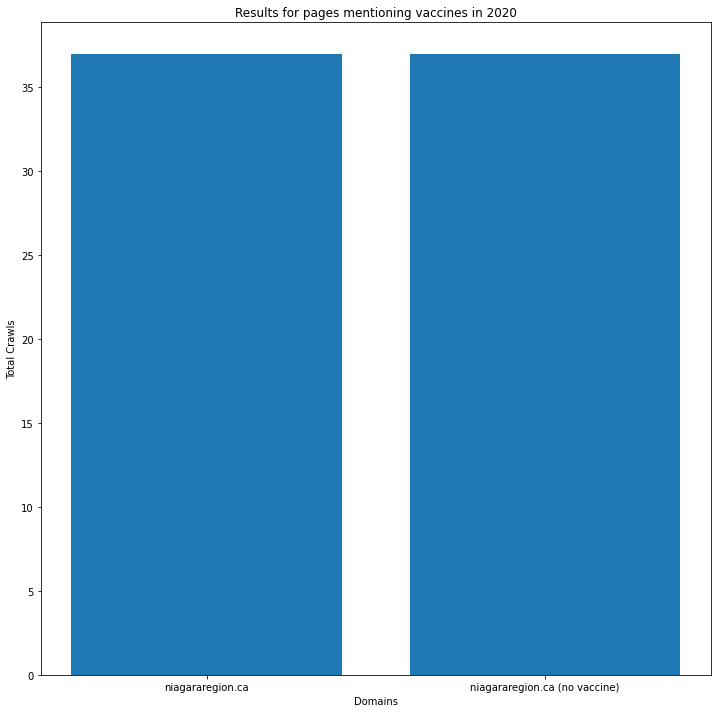

In [ ]:
vac_related = data[data.content.str.contains('vaccine|vaccinated|vaccination', flags=re.IGNORECASE)]
vac_2020 = vac_related[vac_related.crawl_date < '2021-01-01']
no_vac = vac_2020[vac_2020.content.str.contains('Currently, there is no vaccine that protects against coronaviruses in humans')]

fig, ax = plt.subplots(figsize=(12,12))
x_pos = [0,1]
ax.bar(x_pos,[len(vac_2020), len(no_vac)])
ax.set_xticks(x_pos)
ax.set_xticklabels(["niagararegion.ca", "niagararegion.ca (no vaccine)"])
ax.set_ylabel('Total Crawls')
ax.set_xlabel('Domains')
ax.set_title('Results for pages mentioning vaccines in 2020')


This next set of results shows how many vaccines were mentioned in 2021. Niagararegion.ca is an outlier so the graph on the right represents the graph on the left, but with it removed.

It is important to remember that we are matching on keywords and not context, and so whether or not Covid-19 vaccines are being discussed is difficult to know.

Text(0.5, 1.0, 'Results excluding niagararegion.ca')

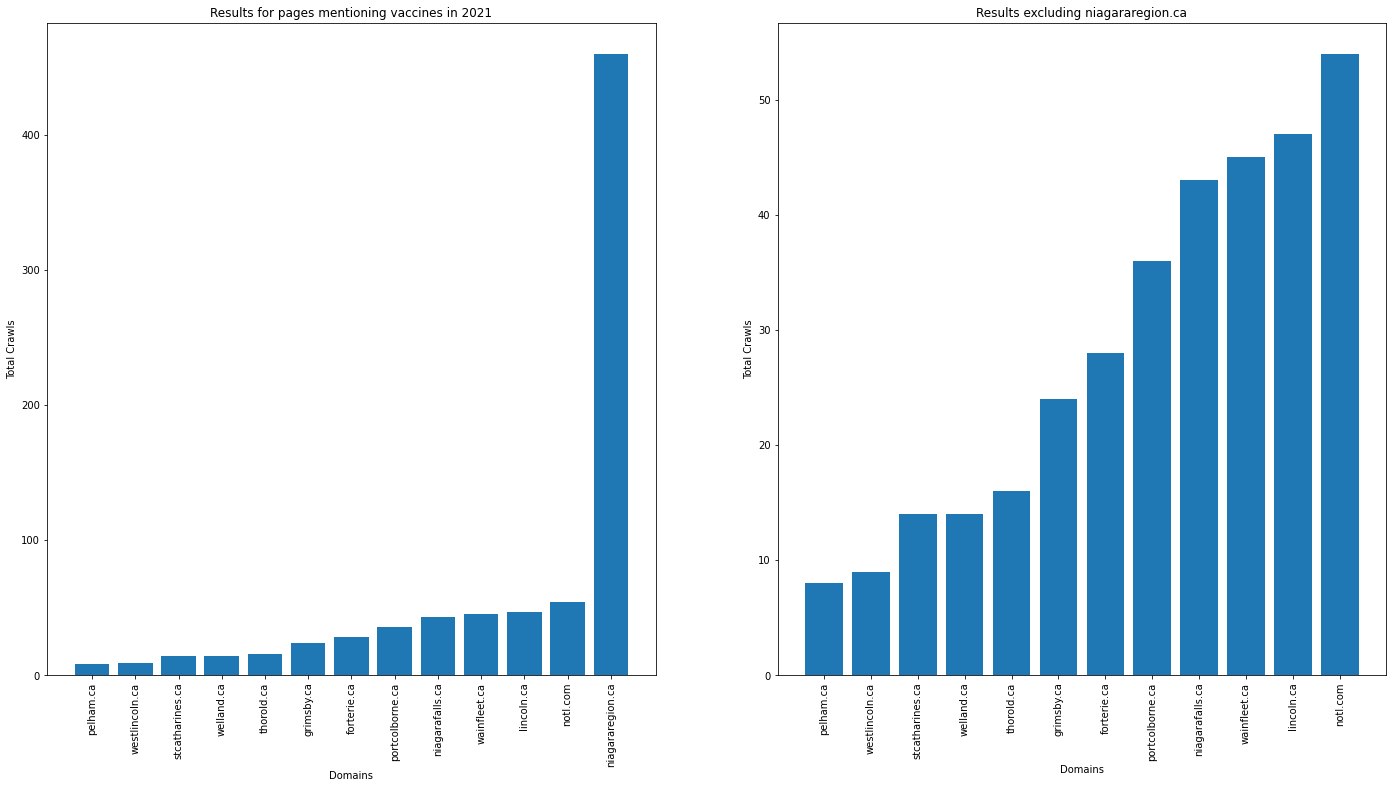

In [ ]:
vac_2021 = vac_related[vac_related.crawl_date >= '2021-01-01']
counts = vac_2021.groupby(['domain']).count().sort_values(by='crawl_date')

fig, (ax, ax2) = plt.subplots(1,2, figsize=(24,12))
x_pos = range(len(counts))
ax.bar(x_pos,counts.crawl_date)
ax.set_xticks(x_pos)
ax.set_xticklabels(counts.index.values, rotation=90)
ax.set_ylabel('Total Crawls')
ax.set_xlabel('Domains')
ax.set_title('Results for pages mentioning vaccines in 2021')

counts = counts[:-1]
x_pos = range(len(counts))
ax2.bar(x_pos,counts.crawl_date)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(counts.index.values, rotation=90)
ax2.set_ylabel('Total Crawls')
ax2.set_xlabel('Domains')
ax2.set_title('Results excluding niagararegion.ca')

In this graph a comparison is made between the total number of crawls and those that contain the vaccine keywords for 2021.

<BarContainer object of 12 artists>

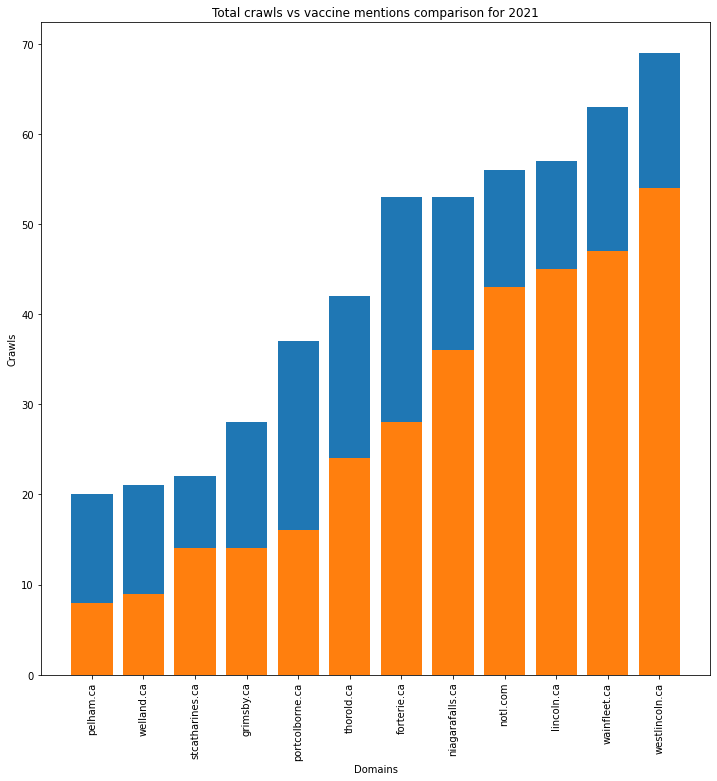

In [ ]:
total_crawls_2021 = data[data.crawl_date >= '2021-01-01'].groupby(['domain']).count()
crawl_count_2021 = total_crawls_2021.sort_values(by='crawl_date')[:-1]

fig, ax = plt.subplots(figsize=(12,12))
x_pos = range(len(crawl_count_2021))
ax.bar(x_pos,crawl_count_2021.crawl_date)
ax.set_xticks(x_pos)
ax.set_xticklabels(crawl_count_2021.index.values, rotation=90)
ax.set_ylabel('Crawls')
ax.set_xlabel('Domains')
ax.set_title('Total crawls vs vaccine mentions comparison for 2021')

ax.bar(x_pos,counts.crawl_date)


And here are graphs showing the month by month results of pages containing references to vaccines.

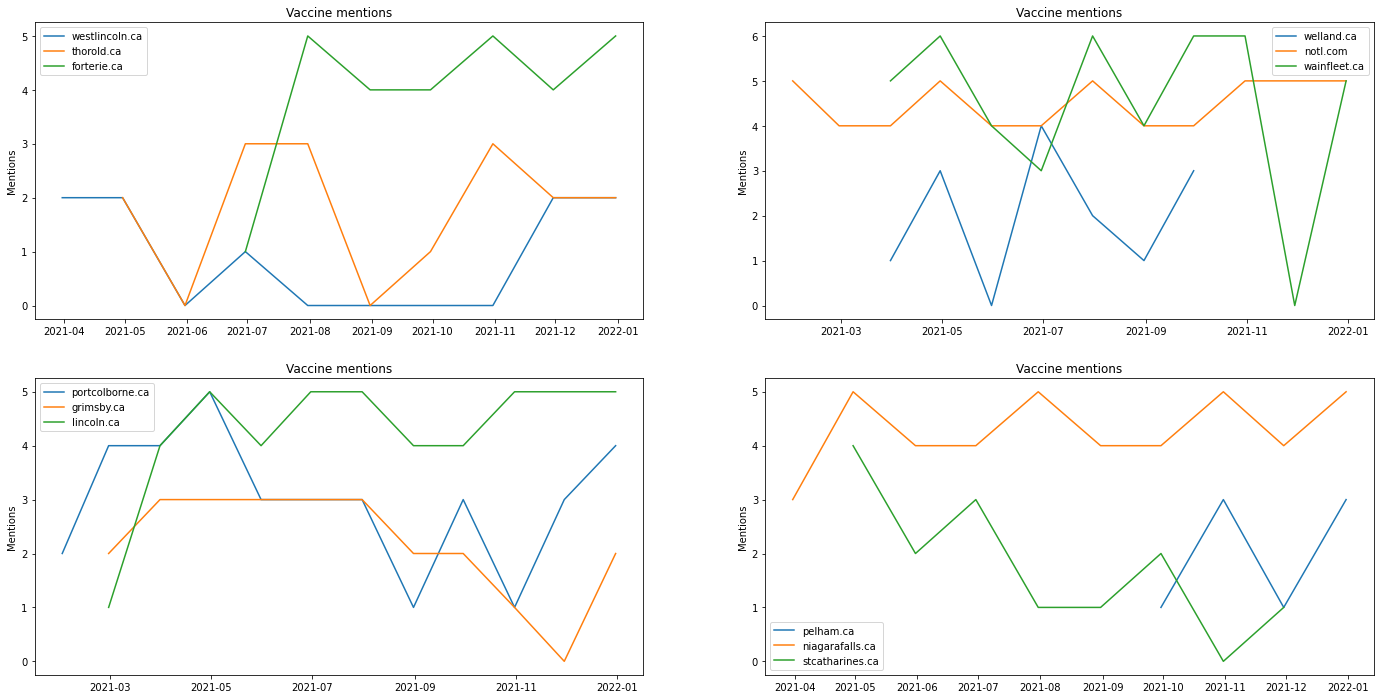

In [ ]:
frames = []
for d in domains:
  index = vac_2021.loc[d].index
  r = vac_2021.loc[d].groupby(pd.Grouper(key="crawl_date", freq="1M")).count()
  r=r.reset_index().set_index(pd.Index([d]*len(r), name='domain'))
  frames.append(r)
result = pd.concat(frames)
no_nr = result[~(result.index == 'niagararegion.ca')]


fig, [[ax1,ax2], [ax3,ax4]] = plt.subplots(2, 2, figsize=(24,12))

def plot_data(ax, domains):
  for d in domains:
    domain_data = no_nr.loc[d].sort_values('crawl_date')
    dates = domain_data.crawl_date
    counts = domain_data.url #url attr used here to get counts but could be any attr other than crawl_date      
    ax.plot(dates, counts, label=d)
  ax.legend()
  ax.set_ylabel('Mentions')
  ax.set_title("Vaccine mentions")

domains_no_nr = list(domains)
domains_no_nr.remove('niagararegion.ca')
plot_data(ax1, domains_no_nr[:3])
plot_data(ax2, domains_no_nr[3:6])
plot_data(ax3, domains_no_nr[6:9])
plot_data(ax4, domains_no_nr[9:])
